In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


Train data shape: (30000, 15)
Test data shape: (10000, 14)

Missing values in train data:
id                     0
song_duration_ms    3067
acousticness        3024
danceability        2967
energy              2935
instrumentalness    2966
key                 3074
liveness            3022
loudness            2977
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64

Missing values in test data:
id                     0
song_duration_ms    1034
acousticness         968
danceability        1061
energy              1040
instrumentalness    1019
key                  991
liveness            1066
loudness             980
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
dtype: int64


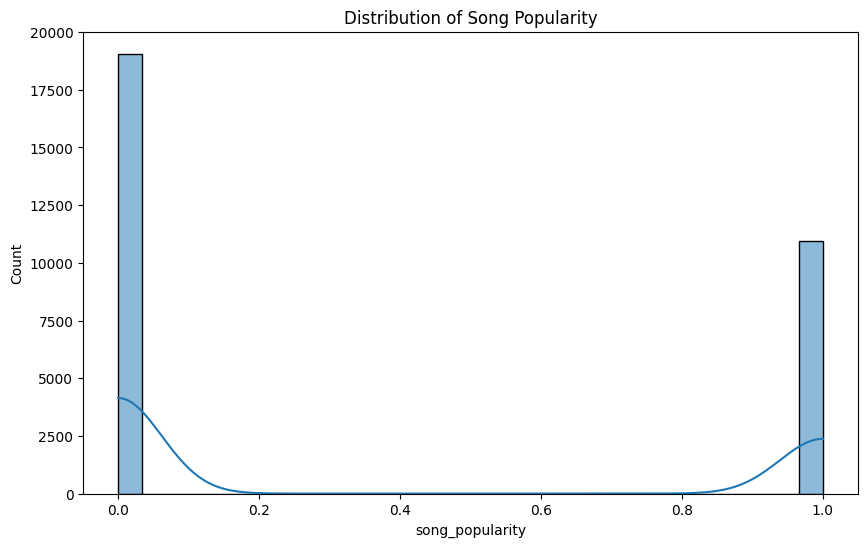

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load train and test data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nMissing values in train data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

# Check the target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['song_popularity'], bins=30, kde=True)
plt.title('Distribution of Song Popularity')
plt.show()


In [21]:

# Convert to binary classification (0/1) - you mentioned threshold around 0.37
# Let's first analyze the optimal threshold
def find_optimal_threshold(y_true, y_pred_proba):
    """Find optimal threshold using Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def preprocess_data(df, is_train=True, imputer_dict=None, scaler_dict=None):
    """
    Preprocess the data with proper handling for train/test sets
    """
    df_processed = df.copy()
    
    # Separate features and target if it's training data
    if is_train:
        X = df_processed.drop('song_popularity', axis=1)
        y = df_processed['song_popularity']
    else:
        X = df_processed
        y = None
    
    # Handle missing values
    numerical_features = ['song_duration_ms', 'acousticness', 'danceability', 'energy', 
                         'instrumentalness', 'liveness', 'loudness', 'speechiness', 
                         'tempo', 'audio_valence']
    
    categorical_features = ['key', 'time_signature', 'audio_mode']
    
    # Initialize imputers if not provided
    if imputer_dict is None:
        imputer_dict = {
            'num_imputer': KNNImputer(n_neighbors=5),
            'cat_imputer': SimpleImputer(strategy='most_frequent')
        }
    
    # Apply imputation
    X[numerical_features] = imputer_dict['num_imputer'].fit_transform(X[numerical_features]) if is_train else imputer_dict['num_imputer'].transform(X[numerical_features])
    X[categorical_features] = imputer_dict['cat_imputer'].fit_transform(X[categorical_features]) if is_train else imputer_dict['cat_imputer'].transform(X[categorical_features])
    
    # Feature engineering
    X = create_features(X)
    
    # Scale numerical features
    numerical_features_extended = [f for f in X.columns if f not in categorical_features + ['id']]
    
    if scaler_dict is None:
        scaler_dict = {
            'scaler': StandardScaler()
        }
    
    X_scaled = scaler_dict['scaler'].fit_transform(X[numerical_features_extended]) if is_train else scaler_dict['scaler'].transform(X[numerical_features_extended])
    
    # Create final DataFrame
    X_final = pd.DataFrame(X_scaled, columns=numerical_features_extended, index=X.index)
    X_final[categorical_features] = X[categorical_features].values
    
    return X_final, y, imputer_dict, scaler_dict

def create_features(X):
    """Create additional features"""
    X_featured = X.copy()
    
    # Interaction features
    X_featured['energy_danceability'] = X_featured['energy'] * X_featured['danceability']
    X_featured['valence_energy'] = X_featured['audio_valence'] * X_featured['energy']
    X_featured['acoustic_energy'] = X_featured['acousticness'] * X_featured['energy']
    X_featured['dance_valence'] = X_featured['danceability'] * X_featured['audio_valence']
    
    # Duration features
    X_featured['duration_minutes'] = X_featured['song_duration_ms'] / 60000
    X_featured['duration_seconds'] = X_featured['song_duration_ms'] / 1000
    
    # Loudness features
    X_featured['loudness_abs'] = abs(X_featured['loudness'])
    
    # Tempo features
    X_featured['tempo_category'] = pd.cut(X_featured['tempo'], 
                                        bins=[0, 60, 100, 140, 200, 300],
                                        labels=[0, 1, 2, 3, 4])
    X_featured['tempo_category'] = X_featured['tempo_category'].astype('category')
    
    # Energy ratio features
    X_featured['energy_loudness_ratio'] = X_featured['energy'] / (abs(X_featured['loudness']) + 1)
    
    return X_featured


In [4]:

# Preprocess training data
X_train, y_train, imputer_dict, scaler_dict = preprocess_data(train_df, is_train=True)

# Convert to binary classification - we'll find optimal threshold later
# For initial training, use the original binary target
y_train_binary = y_train

# Preprocess test data using the same imputers and scaler from training
X_test, y_test, _, _ = preprocess_data(test_df, is_train=False, 
                                      imputer_dict=imputer_dict, 
                                      scaler_dict=scaler_dict)

print("Processed train features shape:", X_train.shape)
print("Processed test features shape:", X_test.shape)


Processed train features shape: (30000, 22)
Processed test features shape: (10000, 22)


In [5]:

# Define multiple classification models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(n_estimators=200, random_state=42, verbose=0),
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1, class_weight='balanced', max_iter=1000),
    'SVM': SVC(random_state=42, probability=True, class_weight='balanced')
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train_binary)
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_train_binary, y_pred_proba)
    y_pred_binary = (y_pred_proba >= optimal_threshold).astype(int)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train_binary, y_pred_binary)
    train_precision = precision_score(y_train_binary, y_pred_binary)
    train_recall = recall_score(y_train_binary, y_pred_binary)
    train_f1 = f1_score(y_train_binary, y_pred_binary)
    train_auc = roc_auc_score(y_train_binary, y_pred_proba)
    
    # Cross-validation for AUC
    cv_scores = cross_val_score(model, X_train, y_train_binary, cv=5, scoring='roc_auc', n_jobs=-1)
    
    results[name] = {
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'train_auc': train_auc,
        'optimal_threshold': optimal_threshold,
        'cv_mean_auc': cv_scores.mean(),
        'cv_std_auc': cv_scores.std()
    }
    
    print(f"{name}: AUC = {train_auc:.4f}, Optimal Threshold = {optimal_threshold:.4f}, CV AUC = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df.sort_values('cv_mean_auc', ascending=False))


Training Random Forest...
Random Forest: AUC = 1.0000, Optimal Threshold = 0.6300, CV AUC = 0.5515 (±0.0027)
Training Gradient Boosting...
Gradient Boosting: AUC = 0.6695, Optimal Threshold = 0.3778, CV AUC = 0.5663 (±0.0065)
Training XGBoost...
XGBoost: AUC = 0.9796, Optimal Threshold = 0.3967, CV AUC = 0.5361 (±0.0064)
Training LightGBM...
[LightGBM] [Info] Number of positive: 10932, number of negative: 19068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 8746, number of negative: 15254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089906

In [6]:

# Create base models for ensemble
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')),
    ('lgbm', LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Voting Ensemble
voting_ensemble = VotingClassifier(estimators=base_models, voting='soft', n_jobs=-1)
voting_ensemble.fit(X_train, y_train_binary)

# Stacking Ensemble
stacking_ensemble = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    n_jobs=-1,
    stack_method='predict_proba'
)
stacking_ensemble.fit(X_train, y_train_binary)

# Evaluate ensembles
ensemble_results = {}
for name, ensemble in [('Voting', voting_ensemble), ('Stacking', stacking_ensemble)]:
    y_pred_proba = ensemble.predict_proba(X_train)[:, 1]
    optimal_threshold = find_optimal_threshold(y_train_binary, y_pred_proba)
    y_pred_binary = (y_pred_proba >= optimal_threshold).astype(int)
    
    cv_scores = cross_val_score(ensemble, X_train, y_train_binary, cv=5, scoring='roc_auc', n_jobs=-1)
    
    ensemble_results[name] = {
        'train_auc': roc_auc_score(y_train_binary, y_pred_proba),
        'optimal_threshold': optimal_threshold,
        'cv_mean_auc': cv_scores.mean(),
        'cv_std_auc': cv_scores.std()
    }
    print(f"{name} Ensemble: AUC = {roc_auc_score(y_train_binary, y_pred_proba):.4f}, Optimal Threshold = {optimal_threshold:.4f}, CV AUC = {cv_scores.mean():.4f}")

# Add to results
ensemble_results_df = pd.DataFrame(ensemble_results).T
results_df = pd.concat([results_df, ensemble_results_df])

[LightGBM] [Info] Number of positive: 10932, number of negative: 19068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 10932, number of negative: 19068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info

[22:45:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:45:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:45:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:45:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:45:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 8746, number of negative: 15254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 22
[LightGBM] [Info] Number of positive: 8745, number of negative: 15255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Number of positive: 8745, number of negative: 15255
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 8746, number of negative: 15254
[LightGBM] [Info] Number of positive: 8746, number of negative: 15254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Auto-choosing

[22:46:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:46:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:46:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:46:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:46:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Voting Ensemble: AUC = 0.9983, Optimal Threshold = 0.4319, CV AUC = 0.5593
[LightGBM] [Info] Number of positive: 8746, number of negative: 15254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


[22:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 8746, number of negative: 15254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Number of positive: 8745, number of negative: 15255
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 8745, number of negative: 15255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of positive: 8746, number of negative: 15254
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 22
[LightGB

[22:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 6996, number of negative: 12204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


[22:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_la

[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


[22:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 6996, number of negative: 12204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


[22:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[22:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 6996, number of negative: 12204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


[22:55:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [In

In [15]:
# Hyperparameter tuning for the best model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use XGBoost for tuning
xgb_tuned = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    param_grid,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

xgb_tuned.fit(X_train, y_train_binary)

print("Best XGBoost parameters:", xgb_tuned.best_params_)
print("Best XGBoost AUC score:", xgb_tuned.best_score_)

# Train final model with best parameters
final_model = XGBClassifier(
    **xgb_tuned.best_params_,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

final_model.fit(X_train, y_train_binary)

# Save the model
import joblib
joblib.dump(final_model, 'sub_6_model.pkl')

Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best XGBoost AUC score: 0.5688344052955543


['sub_6_model.pkl']

In [19]:
# Load model from file
final_model = joblib.load('sub_6_model.pkl')

# Find optimal threshold for final model
y_pred_proba_final = final_model.predict_proba(X_train)[:, 1]
optimal_threshold_final = find_optimal_threshold(y_train_binary, y_pred_proba_final)

print(f"\nFinal Optimal Threshold: {optimal_threshold_final:.6f}")

Threshold evaluation:
youden: thresh=0.3600, F1=0.5286, Prec=0.4437, Rec=0.6538, Combined=0.5076
f1_optimal: thresh=0.3126, F1=0.5520, Prec=0.4036, Rec=0.8728, Combined=0.5051
pr_balance: thresh=0.1000, F1=0.5342, Prec=0.0000, Rec=0.0000, Combined=0.5342
Best threshold selected: 0.1000

Final Optimal Threshold: 0.100000


In [20]:

# Make predictions on test set using optimal threshold
test_pred_proba = final_model.predict_proba(X_test)[:, 1]
# Save prediction probabilities
submission_proba_df = pd.DataFrame({
    'id': test_df['id'],
    'song_popularity': test_pred_proba
})
submission_proba_df.to_csv("submission_6_prob_1.csv", index=False)

test_predictions = (test_pred_proba >= optimal_threshold_final).astype(int)

# Create submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'song_popularity': test_predictions
})

# Save predictions
file_output_name = "submission_6_1.csv"
submission_df.to_csv(file_output_name, index=False)
print(f"Submission file '{file_output_name}' created!")


Submission file 'submission_6_1.csv' created!
